In [1]:
# import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns

# import linregress method from scipy module
from scipy.stats import linregress

In [2]:
# create variable to reference csv file to read to notebook
data = "Resources/cleaned_used_car_data.csv"

In [3]:
# read csv file into Pandas DataFrame
df_raw = pd.read_csv(data)

In [4]:
# preview DataFrame
df_raw.head()

,Unnamed: 0,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,Trim,Engine,BodyType,NumCylinders,DriveType
0,2,119660,8750,2020,33449,55000,Jaguar,XJS,1995,2+2 Cabriolet,4.0L In-Line 6 Cylinder,Convertible,6,RWD
1,3,80773,11600,2019,7852,97200,Ford,Mustang,1968,Stock,289 cu. in. V8,Coupe,8,RWD
2,4,64287,44000,2019,7728,40703,Porsche,911,2002,Turbo X-50,3.6L,Coupe,6,AWD
3,7,5250,70000,2019,7627,6500,Land Rover,Defender,1997,NaN,4.0 Liter Fuel Injected V8,NaN,0,4WD
4,8,29023,1330,2019,7043,167000,Honda,Civic,2001,EX,NaN,Coupe,4,FWD


In [5]:
# create copy of DataFrame with columns selected columns
df_analysis = df_raw[["ID", "pricesold", "yearsold", "zipcode", "Mileage", "Make", "Model", "Year","NumCylinders", "Trim"]]

In [6]:
# filter DataFrame for years that are not realisitic -- save to separate DataFrame
df_yr_exclude = pd.DataFrame(df_analysis.loc[(df_analysis["Year"] < 1950),:])
df_yr_exclude.head()

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders,Trim
25,9704,17000,2019,72223,0,Dodge,Other,1936,0,NaN
30,50079,16450,2019,59806,4327,Ford,TUDOR,1946,8,NaN
38,19071,15000,2019,90260,6756,Ford,Model A,1931,4,Cabriolet
39,96419,22770,2019,5733,31008,Ford,Wagon,1949,8,NaN
62,91901,8200,2019,4284,50000,Cadillac,Other,1937,8,LIMOUSINE


In [7]:
# filter DataFrame where mileage is 0 -- save to separate DataFrame
df_0_miles = pd.DataFrame(df_analysis.loc[(df_analysis["Mileage"] == 0),:]) 
df_0_miles

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders,Trim
25,9704,17000,2019,72223,0,Dodge,Other,1936,0,NaN
50,58533,9600,2019,49068,0,Dodge,Dart,1973,8,Swinger
105,9643,3750,2019,85014,0,Chevrolet,Other Pickups,1966,8,NaN
108,90857,4500,2019,85326,0,Chevrolet,Camaro,1971,0,NaN
137,34684,1280,2019,72601,0,Jeep,CJ,1948,4,NaN
...,...,...,...,...,...,...,...,...,...,...
68673,3728,9000,2019,98277,0,Ford,Mustang,1993,8,Lx
68781,83880,8950,2019,37866,0,Ford,Bronco,1971,0,NaN
68827,89930,16060,2019,80517,0,Dodge,Power Wagon,1947,6,NaN
68829,69214,11010,2019,83651,0,Ford,F-100,1956,8,NaN


In [8]:
# create DataFrame that excludes cars with non-sense years or 0 miles
df_analysis_filtered = pd.DataFrame(df_analysis.loc[(df_analysis["Year"] >= 1950) & (df_analysis["Mileage"] != 0),])
df_analysis_filtered

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders,Trim
0,119660,8750,2020,33449,55000,Jaguar,XJS,1995,6,2+2 Cabriolet
1,80773,11600,2019,7852,97200,Ford,Mustang,1968,8,Stock
2,64287,44000,2019,7728,40703,Porsche,911,2002,6,Turbo X-50
3,5250,70000,2019,7627,6500,Land Rover,Defender,1997,0,NaN
4,29023,1330,2019,7043,167000,Honda,Civic,2001,4,EX
...,...,...,...,...,...,...,...,...,...,...
68955,14948,4200,2019,80233,102700,Ford,Mustang,1977,8,NaN
68956,58814,6500,2019,53132,128000,Ford,E-Series Van,2012,0,NaN
68957,2156,2000,2019,77536,50000,Ford,Bronco,1978,8,NaN
68958,29096,2280,2019,92131,164337,BMW,3-Series,2000,6,328ci


In [9]:
# copy df_analysis_filtered in order to work on CarAge calculation, transformations
df_update_age = df_analysis_filtered.copy()

In [10]:
# calculate age of the car (yearsold - year) & store in variable "CarAge"
CarAge = df_update_age["yearsold"] - df_update_age["Year"]

# add new column to DataFrame -- yearsold - Year
df_update_age["CarAge"] = CarAge

In [11]:
df_ages_to_fix = pd.DataFrame(df_update_age.loc[(df_update_age["CarAge"] < 0),:])
df_ages_to_fix

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders,Trim,CarAge
2103,84970,13900,2019,40214,41819,Chevrolet,Corvette,2020,8,NaN,-1
3025,82310,13000,2019,44224,10307,Toyota,Corolla,2020,4,LE,-1
10691,85641,65100,2019,12538,25,Toyota,Supra,2020,0,GR Supra Launch Edition,-1
10692,54050,63300,2019,12538,50,Toyota,Supra,2020,6,Launch Edition,-1
10693,85952,62200,2019,12538,15,Toyota,Supra,2020,6,GR Supra Launch Edition,-1
17527,72236,19450,2019,48228,279,Chevrolet,Malibu,2020,0,LT,-1
23467,96951,9000,2019,17820,3500,Toyota,Corolla,2020,4,LE,-1
25021,73043,19190,2019,18966,14,Nissan,Altima,2020,4,S,-1
25241,62000,69900,2019,28787,18,Toyota,Supra,2020,6,Gr Launch,-1
29362,95331,95300,2019,81006,50,Ford,Mustang,2020,8,gt 500,-1


In [12]:
# for all cars that have CarAge = -1, replace with 0. Note best practice would be to create separate dataframe using .loc and replace all vs. 1 by 1
df_update_age.at[2103,"CarAge"] = 0
df_update_age.at[3025,"CarAge"] = 0
df_update_age.at[10691,"CarAge"] = 0
df_update_age.at[10692,"CarAge"] = 0
df_update_age.at[10693,"CarAge"] = 0
df_update_age.at[17527,"CarAge"] = 0
df_update_age.at[23467,"CarAge"] = 0
df_update_age.at[25021,"CarAge"] = 0
df_update_age.at[25241,"CarAge"] = 0
df_update_age.at[29362,"CarAge"] = 0
df_update_age.at[41331,"CarAge"] = 0
df_update_age.at[47327,"CarAge"] = 0
df_update_age.at[56819,"CarAge"] = 0

#update Year for 2914 to 2014
df_update_age.at[56622,"CarAge"]=5

In [13]:
# create new series with original CarAge
OriginalCarAge = df_update_age["yearsold"] - df_update_age["Year"]

# add new column to DataFrame -- yearsold - Year
df_update_age["OriginalCarAge"] = OriginalCarAge 

# preview DataFrame with new column
df_update_age.head()

,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,NumCylinders,Trim,CarAge,OriginalCarAge
0,119660,8750,2020,33449,55000,Jaguar,XJS,1995,6,2+2 Cabriolet,25,25
1,80773,11600,2019,7852,97200,Ford,Mustang,1968,8,Stock,51,51
2,64287,44000,2019,7728,40703,Porsche,911,2002,6,Turbo X-50,17,17
3,5250,70000,2019,7627,6500,Land Rover,Defender,1997,0,NaN,22,22
4,29023,1330,2019,7043,167000,Honda,Civic,2001,4,EX,18,18


In [14]:
# add revised car age to df_analysis_filtered
df_analysis_filtered["CarAge"] = df_update_age["CarAge"]
df_analysis_filtered["OriginalCarAge"] = df_update_age["OriginalCarAge"]

In [15]:
# drop records where Original Car Age was <0 (all rows from df_update_age, are excluded)
df_analysis_final = pd.DataFrame(df_analysis_filtered.loc[(df_analysis_filtered["OriginalCarAge"] >= 0),:])

In [16]:
# create dataframes for each car make
df_audi = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Audi",:])
df_bmw = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "BMW",:])
df_buick = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Buick",:])

df_cadillac = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Cadillac",:])
df_chevrolet = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Chevrolet",:])
df_chrysler = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Chrysler",:])

df_dodge = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Dodge",:])
df_ford = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Ford",:])
df_gmc = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "GMC",:])

df_honda = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Honda",:])
df_jaguar = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Jaguar",:])
df_jeep = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Jeep",:])

df_landrover = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Land Rover",:])
df_lexus = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Lexus",:])
df_lincoln = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Lincoln",:])

df_mercedes = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Mercedes-Benz",:])
df_nissan = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Nissan",:])
df_pontiac = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Pontiac",:])

df_porsche = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Porsche",:])
df_subaru = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Subaru",:])
df_toyota = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Toyota",:])
df_vw = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == "Volkswagen",:])

In [17]:
# create distinct list of car make
car_makes = list(df_analysis_filtered["Make"].unique())
car_makes = sorted(car_makes)

In [18]:
# create an empty list to fill with prices sold for each car make
salesprices = []

# use for loop to loop through price sold - determine outliers
for make in car_makes:
    
    #loop through list of cars and filter where car make matches car in for loop
    df_analysis_by_make = df_analysis_filtered.loc[df_analysis_filtered["Make"] == make]
    
    # calculate the number of cars by Make
    cars_per_make = df_analysis_by_make["Make"].count()

    #create dataframe containing car price
    df_price = df_analysis_by_make[["pricesold"]]
    
    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_price["pricesold"]
    salesprices.append(saleprice)
    
    #calculate each car make's IQR for price
    quartiles = saleprice.quantile([.25, .5, .75])
    quartile_1 = quartiles[.25]
    quartile_3 = quartiles[.75]
    iqr = quartile_3 - quartile_1

    # display IQR for sale price of each car
    print(f"There are {cars_per_make} cars included in the saleprice recap for {make}: ")
    print(f" The IQR for the price sold is ${iqr}")
    
    # calculate the bounds
    bound_lower = quartile_1 - (1.5*iqr)
    bound_upper = quartile_3 + (1.5*iqr)
    
    # display the bounds for each car make
    print(f" The lower bound is: ${bound_lower}, the upper bound is: ${bound_upper}")
    
    #check for outliers in each car make
    count_outliers = saleprice.loc[(df_price["pricesold"] >= bound_upper) | 
                                      (df_price["pricesold"] <= bound_lower)].count()

    prct_outlier = (count_outliers / cars_per_make) * 100
    prct_outlier = str(round(prct_outlier,3))
    
    print(f" There are {count_outliers} cars that could be viewed as outliers or {prct_outlier}%\n")

There are 1027 cars included in the saleprice recap for Audi: 
 The IQR for the price sold is $9710.0
 The lower bound is: $-11665.0, the upper bound is: $27175.0
 There are 93 cars that could be viewed as outliers or 9.056%

There are 3535 cars included in the saleprice recap for BMW: 
 The IQR for the price sold is $8315.0
 The lower bound is: $-9472.5, the upper bound is: $23787.5
 There are 290 cars that could be viewed as outliers or 8.204%

There are 1104 cars included in the saleprice recap for Buick: 
 The IQR for the price sold is $10425.0
 The lower bound is: $-13537.5, the upper bound is: $28162.5
 There are 30 cars that could be viewed as outliers or 2.717%

There are 2394 cars included in the saleprice recap for Cadillac: 
 The IQR for the price sold is $11100.0
 The lower bound is: $-13650.0, the upper bound is: $30750.0
 There are 130 cars that could be viewed as outliers or 5.43%

There are 12734 cars included in the saleprice recap for Chevrolet: 
 The IQR for the pric

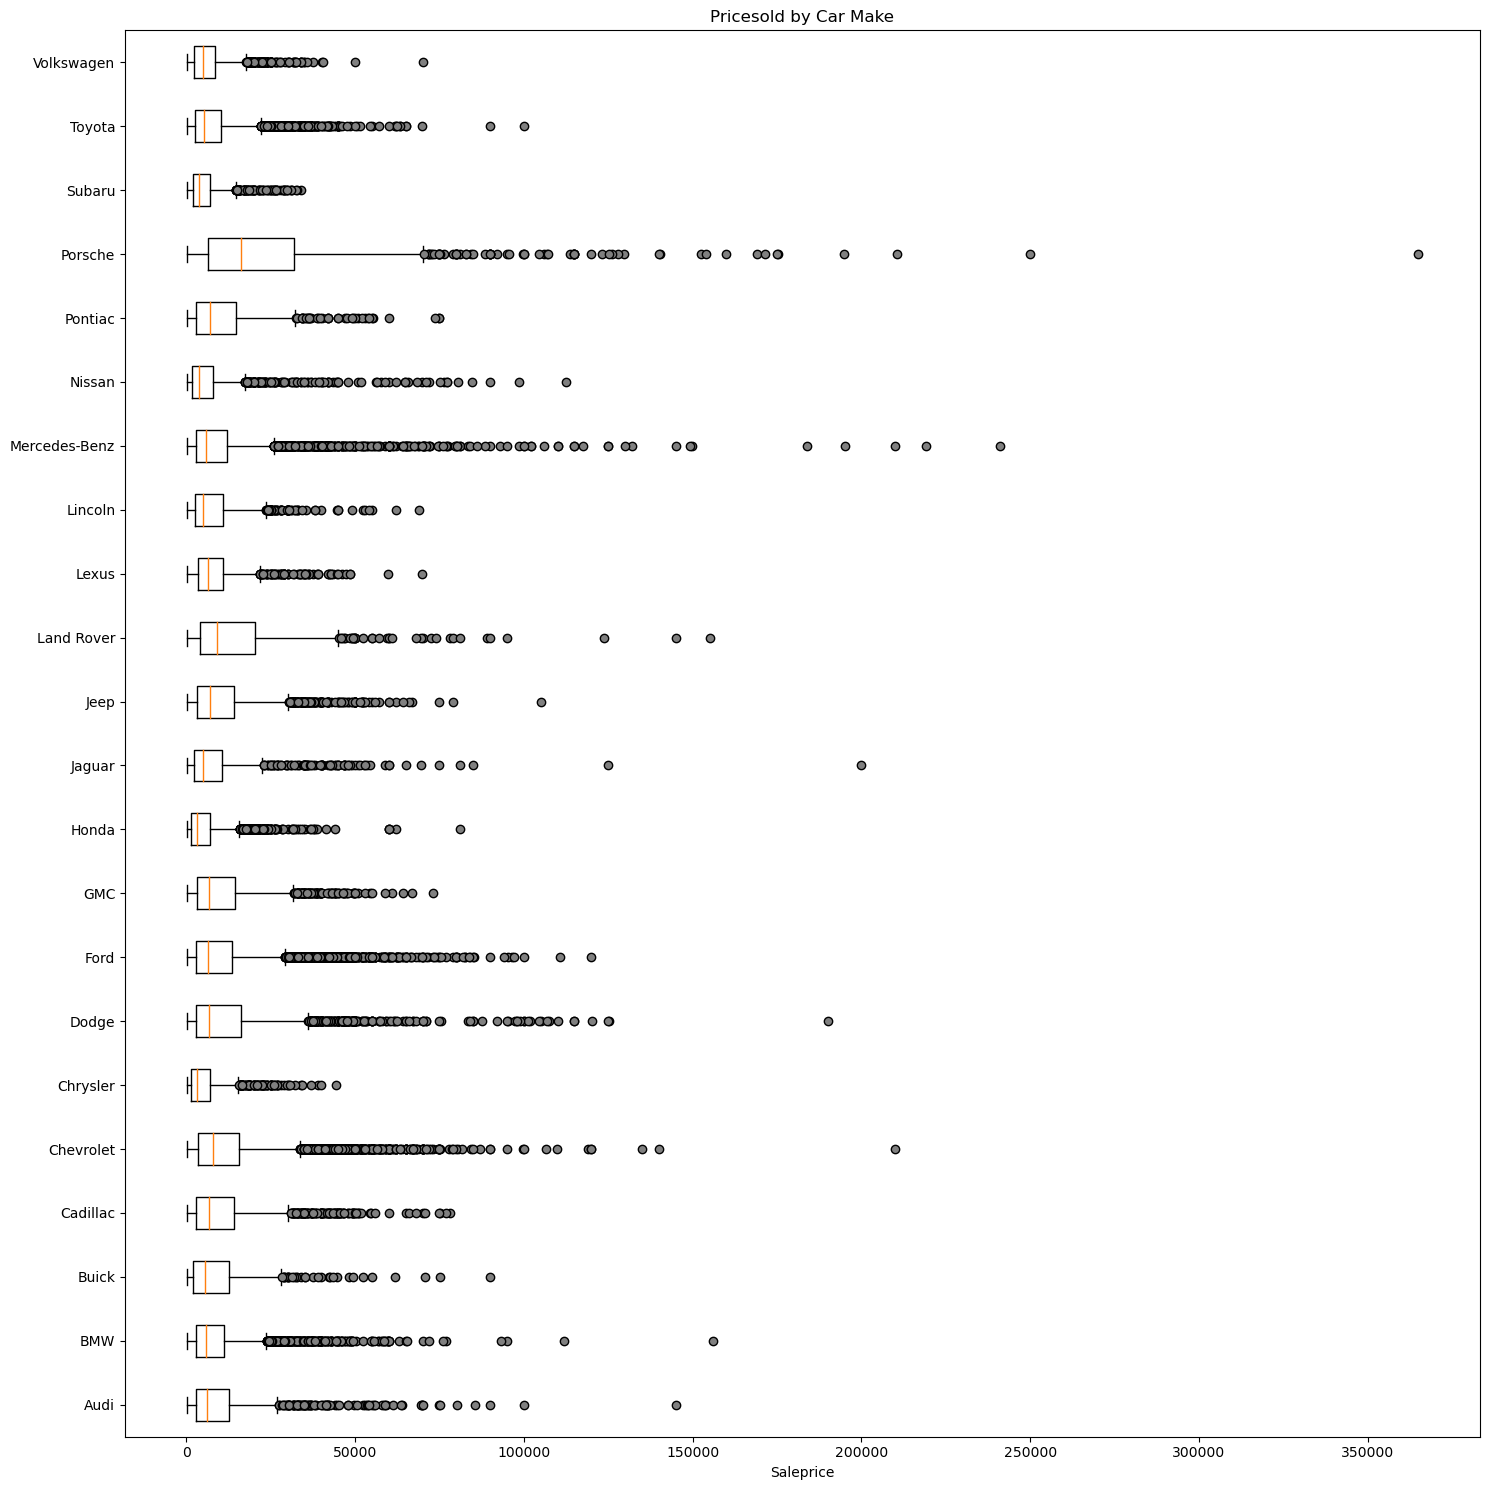

In [19]:
flierprops = dict(marker = 'o', markerfacecolor = 'gray', markeredgecolor = "black")

plt.rcParams["figure.figsize"] = [15, 15]
plt.rcParams["figure.autolayout"] = True

plt.boxplot(salesprices, vert=False, labels = car_makes, flierprops = flierprops)

plt.title("Pricesold by Car Make")
plt.xlabel("Saleprice")
plt.show()

In [20]:
# Define Lin Regression Function for final DataFrame
def lin_regress_total(x, y, x_label, y_label, label_regression): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values
    regress_values = x * slope + intercept
    
  # create string to display regression equation
    line_eq =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    plt.figure(figsize = (7,3.5))

  # define labels using year_sold
    year_sold = ['2018', '2019', '2020']
    
  # generate scatterplot
    scatter = plt.scatter(x, y, c=df_analysis_filtered.yearsold.astype('category'), marker = 'o')
  
  # add legend to graph
    plt.legend(handles=scatter.legend_elements()[0],
               labels=year_sold,
               title = "year sold",
               title_fontsize= 8,
               bbox_to_anchor = (1.17, 0.6), 
               loc='center right',
               fontsize=7)
    
  # add line for linear regression
    plt.plot(x, regress_values, "r-")
    
  # add axis labels
    plt.xlabel(x_label, fontsize = 8)
    plt.ylabel(y_label, fontsize = 8) 

  # adjust tickmark labels
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    
  # add linear regression annotations
    plt.annotate(line_eq, label_regression, fontsize = 8, color = "red")

  # print r-squared value
    print(f"the r-squared value is: {rvalue**2}")
    
  # print correlation coefficient (pearson r)
    correlation = st.pearsonr(x,y)
    print(f"the correlation between factors plotted in the graph is {round(correlation[0],2)}")

In [21]:
# Define Lin Regression Function to regress for individual car-make, legend by year sold
def lin_regress_make(x, y, x_label, y_label, label_regression): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values
    regress_values = x * slope + intercept
    
  # create string to display regression equation
    line_eq =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

  # set scatterplot figure size
    plt.figure(figsize = (7,3.5))
    
  # define labels using year_sold
    year_sold = ['2018', '2019', '2020']
    
  # generate scatterplot
    scatter = plt.scatter(x, y, c=df_regression.yearsold.astype('category'), marker = 'o')
  
  # add legend to graph
    plt.legend(handles=scatter.legend_elements()[0],
               labels=year_sold,
               title = "year sold",
               title_fontsize= 8,
               bbox_to_anchor = (1.17, 0.6), 
               loc='center right',
               fontsize=7)
            
  # add line for linear regression
    plt.plot(x, regress_values, "r-")
    
  # add axis labels
    plt.xlabel(x_label, fontsize = 8)
    plt.ylabel(y_label, fontsize = 8) 

  # adjust tickmark labels
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    
  # add linear regression annotations
    plt.annotate(line_eq, label_regression, fontsize = 8, color = "red")

  # print r-squared value
    print(f"the r-squared value is: {rvalue**2}")
    
  # print correlation coefficient (pearson r)
    correlation = st.pearsonr(x,y)
    print(f"the correlation between factors plotted in the graph is {round(correlation[0],2)}")

In [22]:
# Define Lin Regression Function to regress for individual car-make, legend by model

def lin_regress_model(x, y, x_label, y_label, label_regression): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values
    regress_values = x * slope + intercept
    
  # create string to display regression equation
    line_eq =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

  # set scatterplot figure size
    plt.figure(figsize = (7,3.5))
    
  # define labels using year_sold
    car_model = list(df_regression["Model"].unique())
    
  # generate scatterplot
    scatter = plt.scatter(x, y, c=df_regression.Model.astype('category').cat.codes, marker = 'o')
  
  # add legend to graph
    plt.legend(handles=scatter.legend_elements()[0],
               labels=car_model,
               title = "Model",
               title_fontsize= 8,
               bbox_to_anchor = (1.17, 0.6), 
               loc='center right',
               fontsize=7)
            
  # add line for linear regression
    plt.plot(x, regress_values, "r-")
    
  # add axis labels
    plt.xlabel(x_label, fontsize = 8)
    plt.ylabel(y_label, fontsize = 8) 

  # adjust tickmark labels
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    
  # add linear regression annotations
    plt.annotate(line_eq, label_regression, fontsize = 8, color = "red")

  # print r-squared value
    print(f"the r-squared value is: {rvalue**2}")
    
  # print correlation coefficient (pearson r)
    correlation = st.pearsonr(x,y)
    print(f"the correlation between factors plotted in the graph is {round(correlation[0],2)}")

# Linear Regression - Analyzing impact of mileage & car age on price

the r-squared value is: 0.19708461469885624
the correlation between factors plotted in the graph is -0.44


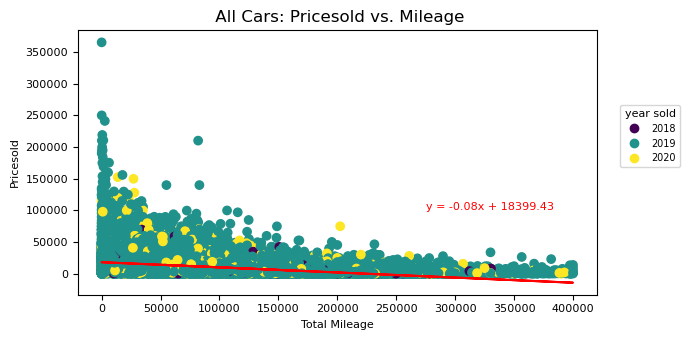

In [23]:
# Linear Regression - Price & Mileage

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_analysis_filtered["Mileage"]
y = df_analysis_filtered["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
lin_regress_total(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f" All Cars: Pricesold vs. Mileage")

# # save image
plt.savefig("Graphs-Analysis/Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.0013458817479851894
the correlation between factors plotted in the graph is -0.04


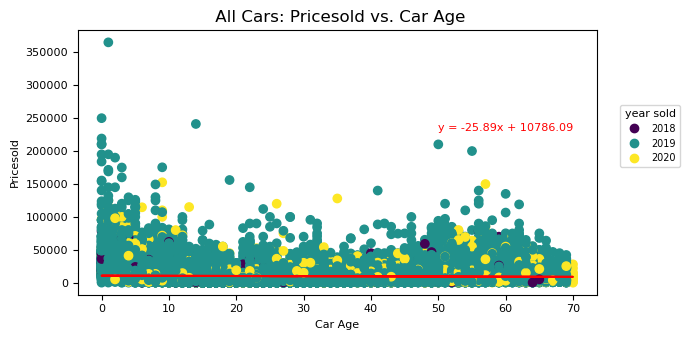

In [24]:
# Linear Regression - Price & Car Age

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_analysis_filtered["CarAge"]
y = df_analysis_filtered["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (50,230000)

# call function
lin_regress_total(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f" All Cars: Pricesold vs. Car Age")

# # save image
plt.savefig("Graphs-Analysis/Price_vs_Age.png")

# display graph
plt.show()

In [25]:
# Use for loop and linear regression function to examine impact of mileage on price for each car make 
def lin_regress_loop(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    correlation = st.pearsonr(x,y)
    
  # display regression statistics for each model
    print(f"The results of {make}'s linear regression are below: ")
    print(f" The r-squared value is: {rvalue**2}")
    print(f" The correlation between pricesold & mileage is {round(correlation[0],2)}\n")

# create an empty list to fill with prices sold for each car make
model_salesprices = []
miles = []

# use for loop to loop through price sold - determine outliers
for make in car_makes:
    
    #loop through list of cars and filter where car make matches car in for loop
    df_analysis_by_make = df_analysis_filtered.loc[df_analysis_filtered["Make"] == make]

    #create dataframe containing car price
    df_scatter = df_analysis_by_make[["pricesold", "Mileage"]]
    
    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_scatter["pricesold"]
    model_salesprices.append(saleprice)
    
    mileage = df_scatter["Mileage"]
    miles.append(mileage)
    
    x = df_scatter["Mileage"]
    y = df_scatter["pricesold"]

    # call function
    lin_regress_loop(x, y)

The results of Audi's linear regression are below: 
 The r-squared value is: 0.3302524244562322
 The correlation between pricesold & mileage is -0.57

The results of BMW's linear regression are below: 
 The r-squared value is: 0.3071733414517728
 The correlation between pricesold & mileage is -0.55

The results of Buick's linear regression are below: 
 The r-squared value is: 0.22849665299046953
 The correlation between pricesold & mileage is -0.48

The results of Cadillac's linear regression are below: 
 The r-squared value is: 0.18793873765917915
 The correlation between pricesold & mileage is -0.43

The results of Chevrolet's linear regression are below: 
 The r-squared value is: 0.19168758601790384
 The correlation between pricesold & mileage is -0.44

The results of Chrysler's linear regression are below: 
 The r-squared value is: 0.2773858241968183
 The correlation between pricesold & mileage is -0.53

The results of Dodge's linear regression are below: 
 The r-squared value is: 

In [26]:
car_makes_ex = ["Subaru"]
car_models = ["Forester","Outback","Legacy","Impreza","WRX","Baja","Tribeca"]
             
def loop_regress_make_model(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    correlation = st.pearsonr(x,y)
    
  # display regression statistics for each model
    print(f"The results of {make}-{model}'s linear regression are below: ")
    print(f" The r-squared value is: {rvalue**2}")
    print(f" The correlation between pricesold & mileage is {round(correlation[0],2)}\n")

# create an empty list to fill with prices sold for each car make
salesprices = []
miles = []

for make in car_makes_ex:
    df_analysis_by_make = df_analysis_filtered.loc[(df_analysis_filtered["Make"] == make) &
                                                   (df_analysis_filtered["yearsold"] == 2019)]
    
    for model in car_models:
        #loop through list of cars and filter where car make matches car in for loop
        df_analysis_by_makemodel = df_analysis_by_make.loc[(df_analysis_by_make["Model"] == model)]
        
        #create dataframe containing car price
        df_scatter_makemodel = df_analysis_by_makemodel[["pricesold", "Mileage"]]
        
        #create a series with the sale price & add to list for that car brand/make
        saleprice = df_scatter_makemodel["pricesold"]
        salesprices.append(saleprice)

        mileage = df_scatter_makemodel["Mileage"]
        miles.append(mileage)
        
        x = df_scatter_makemodel["Mileage"]
        y = df_scatter_makemodel["pricesold"]

        # call function
        loop_regress_make_model(x, y)

The results of Subaru-Forester's linear regression are below: 
 The r-squared value is: 0.4228227157245939
 The correlation between pricesold & mileage is -0.65

The results of Subaru-Outback's linear regression are below: 
 The r-squared value is: 0.5191363557826599
 The correlation between pricesold & mileage is -0.72

The results of Subaru-Legacy's linear regression are below: 
 The r-squared value is: 0.3754767526476625
 The correlation between pricesold & mileage is -0.61

The results of Subaru-Impreza's linear regression are below: 
 The r-squared value is: 0.3096515157614
 The correlation between pricesold & mileage is -0.56

The results of Subaru-WRX's linear regression are below: 
 The r-squared value is: 0.5471177130248566
 The correlation between pricesold & mileage is -0.74

The results of Subaru-Baja's linear regression are below: 
 The r-squared value is: 0.1434536087549663
 The correlation between pricesold & mileage is -0.38

The results of Subaru-Tribeca's linear regre

## Audi - Linear Regressions

the r-squared value is: 0.3302524244562322
the correlation between factors plotted in the graph is -0.57


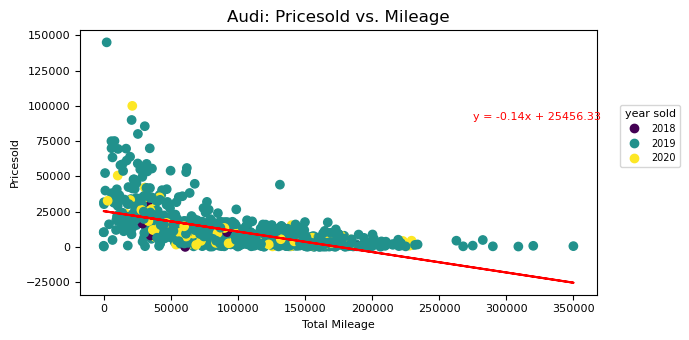

In [27]:
brand = "Audi"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,90000)

# call function
lin_regress_make(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Audi-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.33829428989115384
the correlation between factors plotted in the graph is -0.58


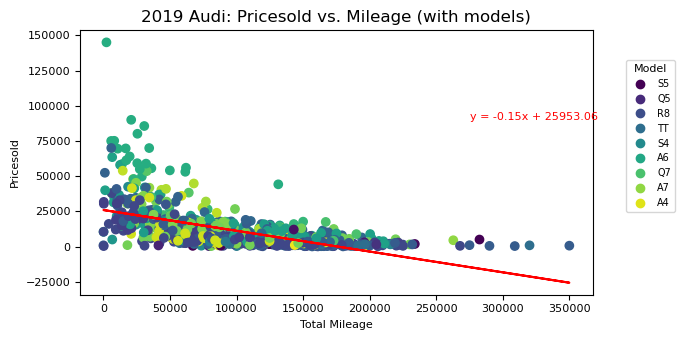

In [28]:
brand = "Audi"
yearsold = 2019

df_regression = pd.DataFrame(df_analysis_filtered.loc[(df_analysis_filtered["Make"] == brand)
                                                      & (df_analysis_filtered["yearsold"] == yearsold),:]) 

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,90000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{yearsold} {brand}: Pricesold vs. Mileage (with models)")

# save image
# plt.savefig("Graphs-Analysis/Audi-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.25303470616063967
the correlation between factors plotted in the graph is -0.5


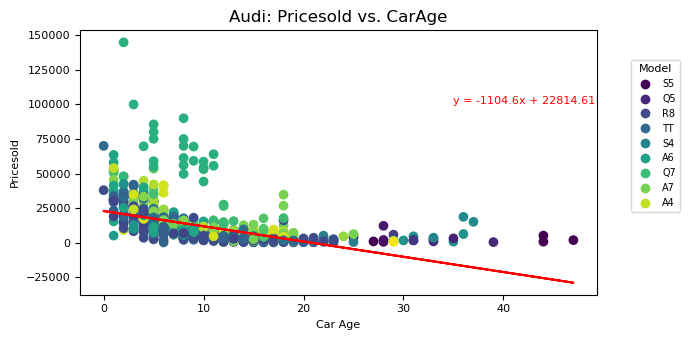

In [29]:
brand = "Audi"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (35,100000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Audi-Price_vs_Age.png")

# display graph
plt.show()

# BMW - Linear Regressions

the r-squared value is: 0.3071733414517728
the correlation between factors plotted in the graph is -0.55


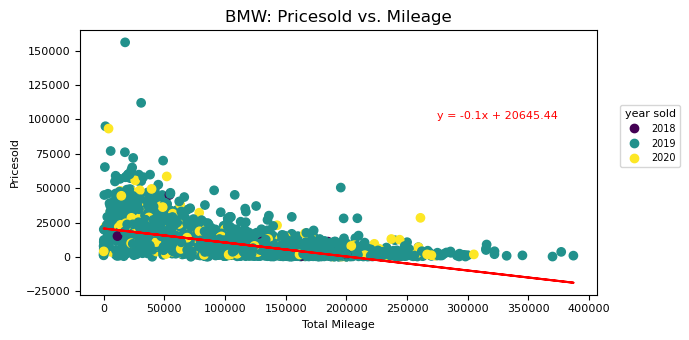

In [30]:
brand = "BMW"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
lin_regress_make(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/BMW-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.30766286161783357
the correlation between factors plotted in the graph is -0.55


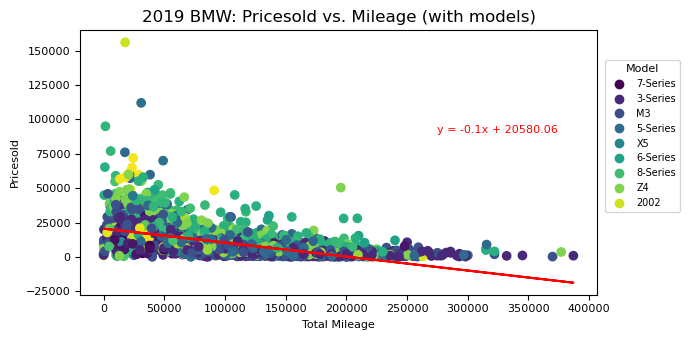

In [31]:
brand = "BMW"
yearsold = 2019

df_regression = pd.DataFrame(df_analysis_filtered.loc[(df_analysis_filtered["Make"] == brand)
                                                      & (df_analysis_filtered["yearsold"] == yearsold),:]) 

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,90000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{yearsold} {brand}: Pricesold vs. Mileage (with models)")

# save image
plt.savefig("Graphs-Analysis/BMW-2019 - Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.1249645350171096
the correlation between factors plotted in the graph is -0.35


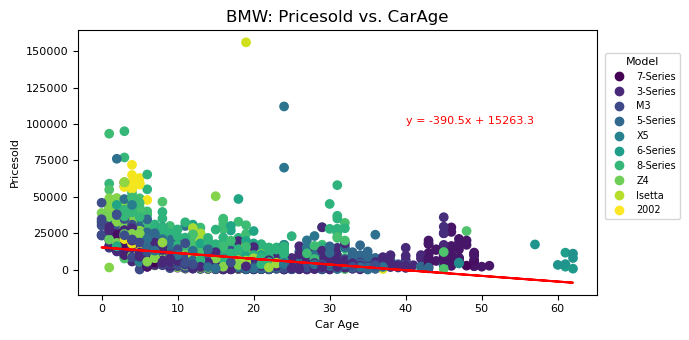

In [32]:
brand = "BMW"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/BMW-Price_vs_Age.png")

# display graph
plt.show()

# Buick - Linear Regressions

the r-squared value is: 0.22849665299046953
the correlation between factors plotted in the graph is -0.48


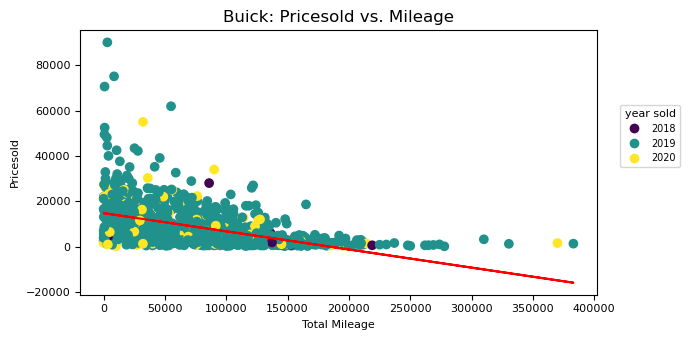

In [33]:
brand = "Buick"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
lin_regress_make(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Buick-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.2357303746509359
the correlation between factors plotted in the graph is -0.49


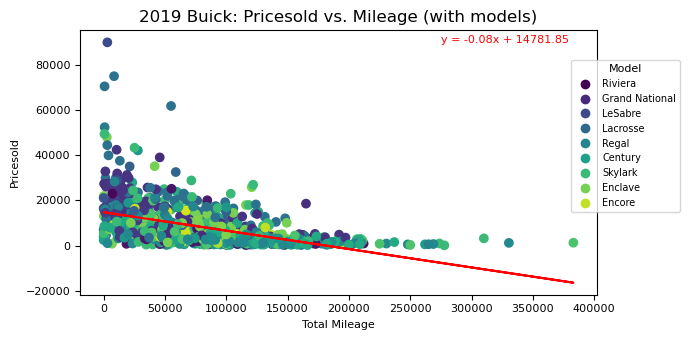

In [34]:
brand = "Buick"
yearsold = 2019

df_regression = pd.DataFrame(df_analysis_filtered.loc[(df_analysis_filtered["Make"] == brand)
                                                      & (df_analysis_filtered["yearsold"] == yearsold),:]) 

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,90000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{yearsold} {brand}: Pricesold vs. Mileage (with models)")

# save image
plt.savefig("Graphs-Analysis/Buick-2019 - Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.0009100030248659784
the correlation between factors plotted in the graph is -0.03


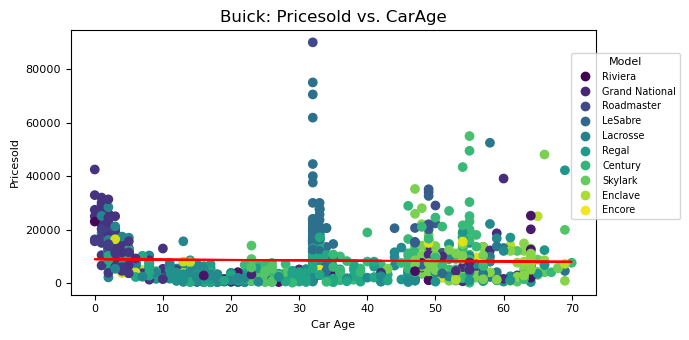

In [35]:
brand = "Buick"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Buick-Price_vs_Age.png")

# display graph
plt.show()

# Cadillac - Linear Regressions

the r-squared value is: 0.18793873765917915
the correlation between factors plotted in the graph is -0.43


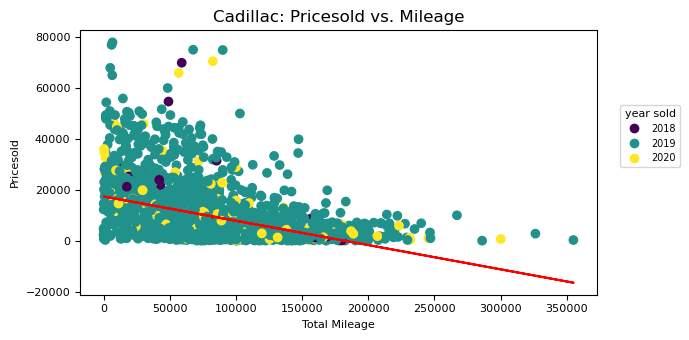

In [36]:
brand = "Cadillac"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
lin_regress_make(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Cadillac-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.18141282755185612
the correlation between factors plotted in the graph is -0.43


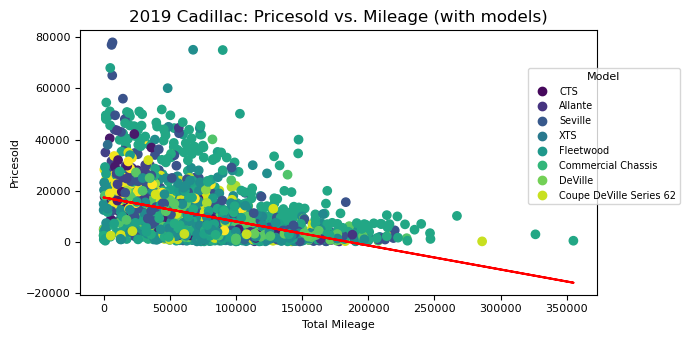

In [37]:
brand = "Cadillac"
yearsold = 2019

df_regression = pd.DataFrame(df_analysis_filtered.loc[(df_analysis_filtered["Make"] == brand)
                                                      & (df_analysis_filtered["yearsold"] == yearsold),:]) 

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,90000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{yearsold} {brand}: Pricesold vs. Mileage (with models)")

# save image
plt.savefig("Graphs-Analysis/Cadillac-2019 - Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.05228676885643168
the correlation between factors plotted in the graph is -0.23


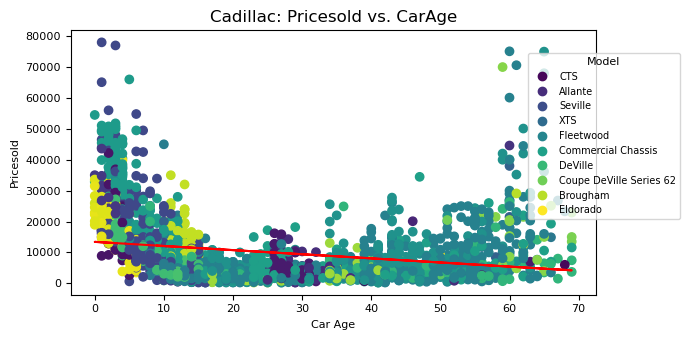

In [38]:
brand = "Cadillac"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,100000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{brand}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Cadillac-Price_vs_Age.png")

# display graph
plt.show()

In [39]:
# brand = "Chevrolet"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,100000)

# # call function
# lin_regress_brand(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Chevrolet-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [40]:
# brand = "Chevrolet"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# lin_regress_brand(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Chevrolet-Price_vs_Age.png")

# # display graph
# plt.show()

In [41]:
# brand = "Chrysler"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,40000)

# # call function
# lin_regress_brand(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Chrysler-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [42]:
# brand = "Chrysler"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,40000)

# # call function
# lin_regress_brand(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Chrysler-Price_vs_Age.png")

# # display graph
# plt.show()

In [43]:
# brand = "Dodge"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,100000)

# # call function
# lin_regress_brand(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Dodge-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [44]:
# brand = "Dodge"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# lin_regress_brand(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Dodge-Price_vs_Age.png")

# # display graph
# plt.show()

In [45]:
# brand = "Ford"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,100000)

# # call function
# lin_regress_brand(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Ford-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [46]:
# brand = "Ford"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# lin_regress_brand(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Ford-Price_vs_Age.png")

# # display graph
# plt.show()

In [47]:
# brand = "GMC"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,50000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/GMC-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [48]:
# brand = "GMC"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,50000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/GMC-Price_vs_Age.png")

# # display graph
# plt.show()

In [49]:
# brand = "Honda"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,60000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Honda-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [50]:
# brand = "Honda"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,60000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Honda-Price_vs_Age.png")

# # display graph
# plt.show()

In [51]:
# brand = "Jaguar"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Jaguar-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [52]:
# brand = "Jaguar"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Jaguar-Price_vs_Age.png")

# # display graph
# plt.show()

In [53]:
# brand = "Jeep"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Jeep-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [54]:
# brand = "Jeep"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Jeep-Price_vs_Age.png")

# # display graph
# plt.show()

In [55]:
# brand = "Land Rover"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Land Rover-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [56]:
# brand = "Land Rover"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Land Rover-Price_vs_Age.png")

# # display graph
# plt.show()

In [57]:
# brand = "Lexus"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Lexus-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [58]:
# brand = "Lexus"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Lexus-Price_vs_Age.png")

# # display graph
# plt.show()

In [59]:
# brand = "Lincoln"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,60000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Lincoln-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [60]:
# brand = "Lincoln"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,60000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Lincoln-Price_vs_Age.png")

# # display graph
# plt.show()

In [61]:
# brand = "Mercedes-Benz"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Mercedes-Benz-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [62]:
# brand = "Mercedes-Benz"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Mercedes-Benz-Price_vs_Age.png")

# # display graph
# plt.show()

In [63]:
# brand = "Nissan"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Nissan-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [64]:
# brand = "Nissan"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Nissan-Price_vs_Age.png")

# # display graph
# plt.show()

In [65]:
# brand = "Pontiac"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,60000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Pontiac-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [66]:
# brand = "Pontiac"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,60000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Pontiac-Price_vs_Age.png")

# # display graph
# plt.show()

In [67]:
# brand = "Porsche"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (200000,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Porsche-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [68]:
# brand = "Porsche"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Porsche-Price_vs_Age.png")

# # display graph
# plt.show()

In [69]:
# brand = "Subaru"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,40000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Subaru-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [70]:
# brand = "Subaru"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,40000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Subaru-Price_vs_Age.png")

# # display graph
# plt.show()

In [71]:
# brand = "Toyota"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Toyota-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [72]:
# brand = "Toyota"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,100000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Toyota-Price_vs_Age.png")

# # display graph
# plt.show()

In [73]:
# brand = "Volkswagen"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["Mileage"]
# y = df_regression["pricesold"]
# x_label = "Total Mileage"
# y_label = "Pricesold"
# label_regression = (275000,60000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. Mileage")

# # save image
# plt.savefig("Graphs-Analysis/Volkswagen-Price_vs_Mileage.png")

# # display graph
# plt.show()

In [74]:
# brand = "Volkswagen"

# df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == brand ,:])

# # assign values to arguments to pass into plot_lin_regress paramaters 
# x = df_regression["CarAge"]
# y = df_regression["pricesold"]
# x_label = "Car Age"
# y_label = "Pricesold"
# label_regression = (40,60000)

# # call function
# plot_lin_regress(x, y, x_label, y_label, label_regression)

# # add chart tile
# plt.title(f"{brand}: Pricesold vs. CarAge")

# # save image
# plt.savefig("Graphs-Analysis/Volkswagen-Price_vs_Age.png")

# # display graph
# plt.show()

In [75]:
# calculate the total $ sold by make
price_make = df_analysis_filtered.groupby(["Make"]).sum()["pricesold"]
price_make

Make
Audi              10980700
BMW               32903370
Buick              9388240
Cadillac          24776210
Chevrolet        149102100
Chrysler           5611500
Dodge             43904340
Ford             131412720
GMC               17423770
Honda             13118440
Jaguar             8229610
Jeep              31007960
Land Rover        12267030
Lexus              8012330
Lincoln           10079520
Mercedes-Benz     44469750
Nissan            11524330
Pontiac           16095290
Porsche           34263830
Subaru             5417490
Toyota            36145030
Volkswagen        15114200
Name: pricesold, dtype: int64

In [76]:
# calculate the number of cars by Make
cars_per_make = df_analysis_filtered["Make"].value_counts()
cars_per_make

Ford             13139
Chevrolet        12734
Toyota            4401
Mercedes-Benz     4121
Dodge             3699
BMW               3535
Jeep              3014
Cadillac          2394
Honda             2361
Volkswagen        2316
Nissan            1647
GMC               1644
Pontiac           1635
Porsche           1436
Lincoln           1236
Buick             1104
Audi              1027
Chrysler           986
Subaru             915
Lexus              894
Jaguar             835
Land Rover         810
Name: Make, dtype: int64

In [77]:
# calculate the average price by car make
avg_price_make = df_analysis_filtered.groupby(["Make"]).mean()["pricesold"]
avg_price_make

Make
Audi             10692.015579
BMW               9307.884017
Buick             8503.840580
Cadillac         10349.294069
Chevrolet        11708.975970
Chrysler          5691.176471
Dodge            11869.245742
Ford             10001.729203
GMC              10598.400243
Honda             5556.306650
Jaguar            9855.820359
Jeep             10287.976111
Land Rover       15144.481481
Lexus             8962.337808
Lincoln           8154.951456
Mercedes-Benz    10791.009464
Nissan            6997.164542
Pontiac           9844.214067
Porsche          23860.605850
Subaru            5920.754098
Toyota            8212.912974
Volkswagen        6525.993092
Name: pricesold, dtype: float64

In [78]:
# calculate the average price by car make_model
avg_price_make_model = df_analysis_filtered.groupby(["Make","Model"]).mean()["pricesold"]
avg_price_make_model

Make        Model                
Audi        100                       2106.666667
            200                       1730.000000
            200 20V                   1840.000000
            200 Quattro              12100.000000
            4000 Quattro              3000.000000
                                         ...     
Volkswagen  Type III                  6938.000000
            Vanagon                   5525.000000
            Volkswagon Dune Buggy     5700.000000
            dune buggy                5380.000000
            jetta                     1010.000000
Name: pricesold, Length: 1464, dtype: float64

In [79]:
# calculate the number of cars by car make_model
number_make_model = df_analysis_filtered.groupby(["Make","Model"]).count()["ID"]
number_make_model

Make        Model                
Audi        100                      6
            200                      1
            200 20V                  1
            200 Quattro              1
            4000 Quattro             1
                                    ..
Volkswagen  Type III                 5
            Vanagon                  2
            Volkswagon Dune Buggy    1
            dune buggy               1
            jetta                    1
Name: ID, Length: 1464, dtype: int64